# Medical Insurance Cost
Lien externe vers le dataset kaggle : [ici](https://www.kaggle.com/datasets/rahulvyasm/medical-insurance-cost-prediction/data)

#### Contexte

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data/medical_insurance.csv", sep=",")
df.drop_duplicates(inplace=True)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [77]:
import warnings
warnings.filterwarnings('ignore')

Hypothèses : 
- Les coûts de l'assurance maladie augmentent avec l'âge, l'IMC, le tabac
- Le tabac devrait être le facteur le plus important pour déterminer le coût de l'assurance maladie
- Grosse différence entre les fumeurs et les non-fumeurs.
- Aucune différence entre homme / femme
- Le nombre d'enfants n'a pas d'impact sur le coût de l'assurance maladie -> à vérifier sur l'impact avec le sexe
- la région a un impact sur le coût de l'assurance maladie
- IMC + tabac -> impact sur le coût de l'assurance maladie

Il y a 7 colonnes dans le dataset :
- age : age du bénéficiaire principal
- sex : sexe du bénéficiaire principal
- bmi : indice de masse corporelle
- children : nombre d'enfants couverts par l'assurance-santé / nombre de personnes à charge
- smoker : fumeur ou non
- region : la région du pays où réside le bénéficiaire (nord-est, sud-est, sud-ouest, nord-ouest)
- charges : coûts médicaux individuels facturés par la compagnie d'assurance : **variable cible**


Il y a 2772 observations dans le dataset et il ne contient pas de valeurs manquantes.

#### EDA

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


Il y a 7 colonnes dans le dataset :
- age : age du bénéficiaire principal
- sex : sexe du bénéficiaire principal
- bmi : indice de masse corporelle
- children : nombre d'enfants couverts par l'assurance-santé / nombre de personnes à charge
- smoker : fumeur ou non
- region : la région du pays où réside le bénéficiaire (nord-est, sud-est, sud-ouest, nord-ouest)
- charges : coûts médicaux individuels facturés par la compagnie d'assurance : **variable cible**


Il y a 1337 observations dans le dataset et il ne contient pas de valeurs manquantes.

In [79]:
df.shape

(1337, 7)

On remarque que les données sont répétitives, il n'y a que 1338 combinaisons uniques de valeurs pour les 6 premières colonnes. Cela signifie que les données ont été copiées plusieurs fois pour augmenter la taille du dataset. On ne garde donc que les combinaisons uniques de valeurs.

In [80]:
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


In [81]:
for col in ["children", "smoker", "region", "sex"]:
    print(df[col].value_counts(), "\n")

children
0    573
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64 

smoker
no     1063
yes     274
Name: count, dtype: int64 

region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64 

sex
male      675
female    662
Name: count, dtype: int64 



In [82]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le_smoker = LabelEncoder()
le_sex = LabelEncoder()
oh_region = OneHotEncoder(handle_unknown="ignore")

df["smoker"] = le_smoker.fit_transform(df["smoker"])
df["sex"] = le_sex.fit_transform(df["sex"])

# One hot encoding sur la colonne region
encoded_region = oh_region.fit_transform(df[["region"]])
encoded_region = pd.DataFrame(encoded_region.toarray(), columns=["northeast", "northwest", "southeast", "southwest"])
df.drop(columns=["region"], inplace=True)
df = pd.merge(df, encoded_region, left_index=True, right_index=True)

# Analyse IMC

In [83]:
nb = df[df["bmi"]<24.9].count()
total = df["bmi"].count()
print("Pourcentage de personne avec un IMC inférieur à 24.9 : ", (nb[0]/total)*100)
print(nb)

Pourcentage de personne avec un IMC inférieur à 24.9 :  18.113772455089823
age          242
sex          242
bmi          242
children     242
smoker       242
charges      242
northeast    242
northwest    242
southeast    242
southwest    242
dtype: int64


In [84]:
q1 = df["bmi"].quantile(0.25)
q2 = df["bmi"].quantile(0.5)
q3 = df["bmi"].quantile(0.75)

df["bmi_cat"] = df["bmi"].apply(lambda x: 1 if x < q1 else 2 if x < q2 else 3 if x < q3 else 4)

<Figure size 1000x600 with 0 Axes>

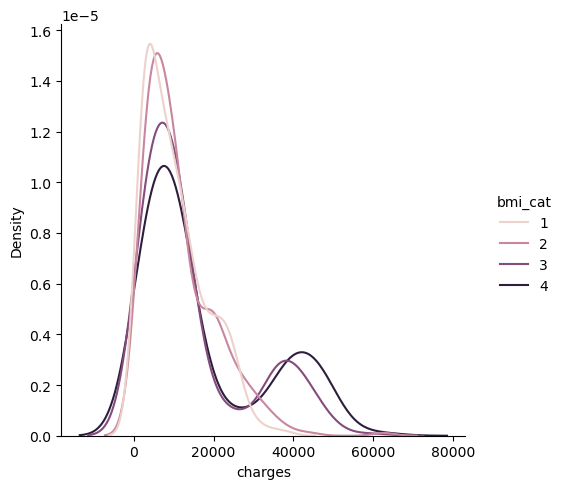

In [85]:
plt.figure(figsize=(10, 6))
sns.displot(df, x="charges", hue="bmi_cat", kind="kde", )
plt.show()

In [86]:
# Correlation of bmi cat and charges
encoded_bmi = pd.get_dummies(df["bmi_cat"], prefix="bmi")
encoded_bmi["charges"] = df["charges"]
correlation = encoded_bmi.corr()["charges"].sort_values(ascending=False)
print(correlation)

charges    1.000000
bmi_4      0.177849
bmi_3      0.052202
bmi_2     -0.089167
bmi_1     -0.141150
Name: charges, dtype: float64


In [87]:
df.head()

,age,sex,bmi,children,smoker,charges,northeast,northwest,southeast,southwest,bmi_cat
0,19,0,27.900,0,1,16884.92400,0.0,0.0,0.0,1.0,2
1,18,1,33.770,1,0,1725.55230,0.0,0.0,1.0,0.0,3
2,28,1,33.000,3,0,4449.46200,0.0,0.0,1.0,0.0,3
3,33,1,22.705,0,0,21984.47061,0.0,1.0,0.0,0.0,1
4,32,1,28.880,0,0,3866.85520,0.0,1.0,0.0,0.0,2


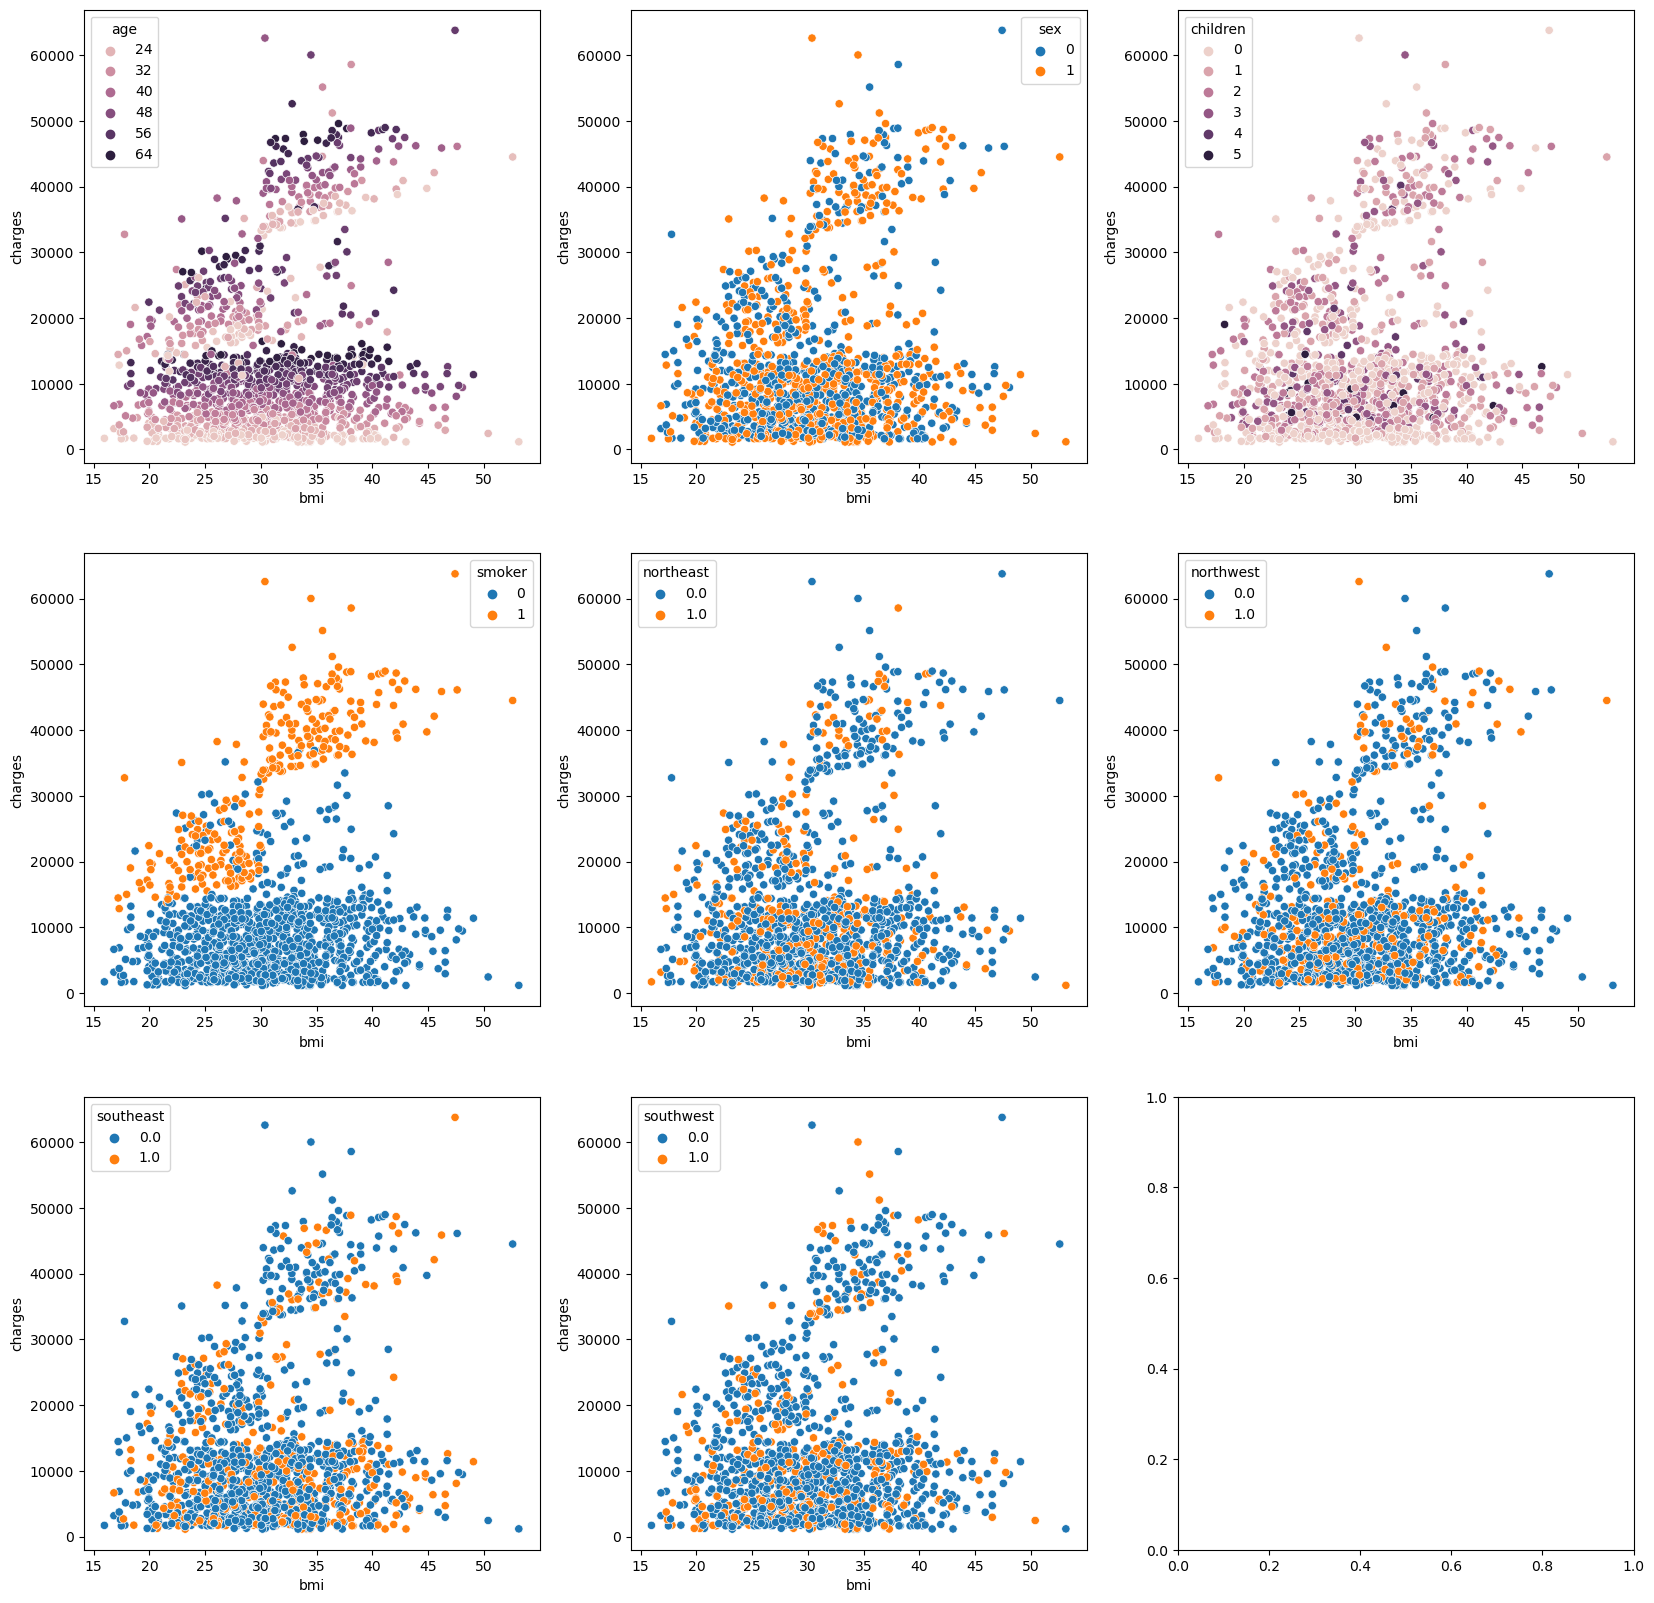

In [88]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

for i in enumerate(['age', 'sex', 'children', 'smoker', 'northeast','northwest', 'southeast', 'southwest']):
    sns.scatterplot(x=df["bmi"], y=df["charges"], hue=df[i[1]], ax=axes[i[0]//3, i[0]%3])

# Analyse Tabac

In [89]:
df.drop(columns=["bmi_cat"], inplace=True)

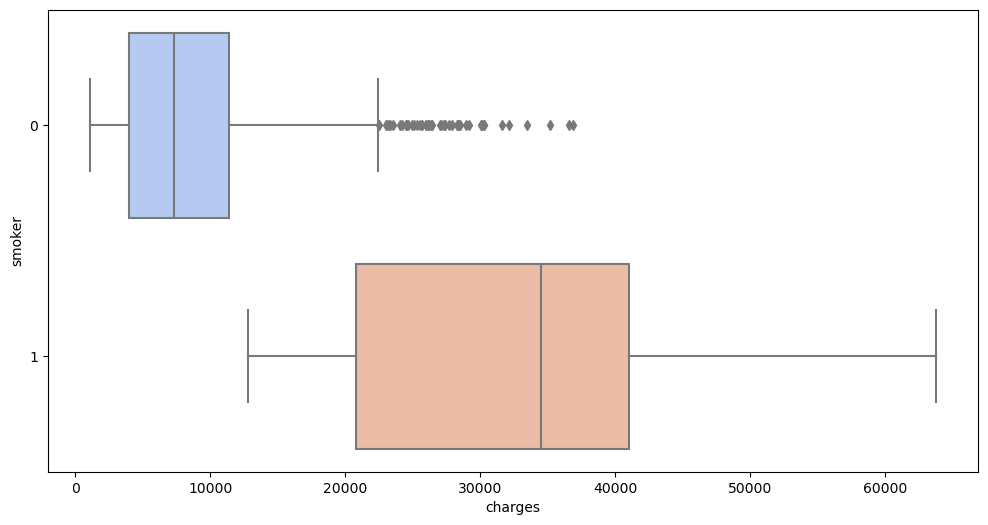

In [90]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="charges", y="smoker", data=df, palette="coolwarm", orient="h")
plt.show()

<Axes: xlabel='bmi', ylabel='charges'>

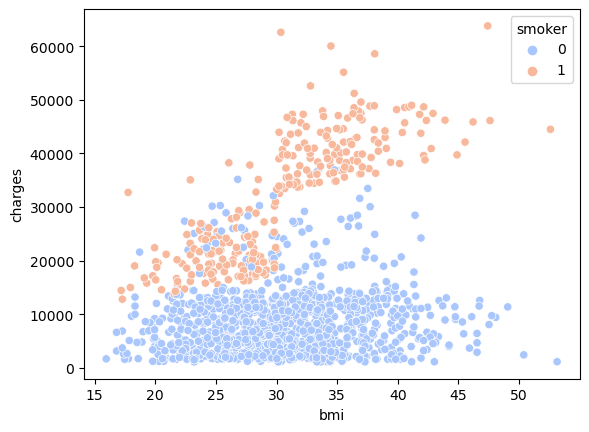

In [91]:
sns.scatterplot(x="bmi", y="charges", data=df, hue="smoker", palette="coolwarm")

In [92]:
# Les charges sont-elles corrélées à la région ?
plt.figure(figsize=(12, 6))
sns.boxplot(x="charges", y="region", data=df, palette="coolwarm", orient="h")
plt.show()

ValueError: Could not interpret input 'region'

<Figure size 1200x600 with 0 Axes>

# Analyse Age

In [ ]:
# Multi boxplot for BMI, age, Charges
plt.figure(figsize=(4, 6))
sns.boxplot(y=df['age'])
plt.title('Boite à moustache pour Age')
plt.show()

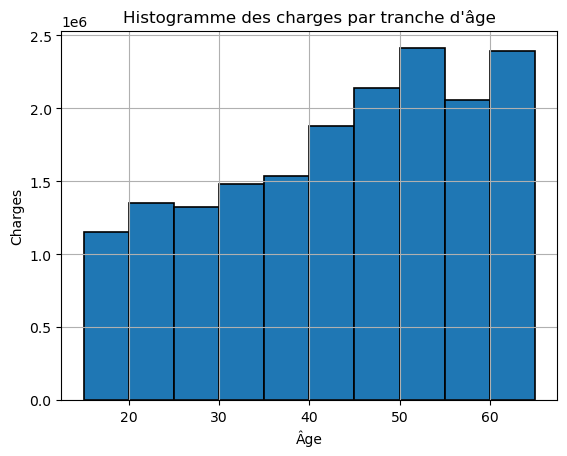

In [ ]:
bins = range(15, 70, 5)

plt.hist(df['age'], bins=bins, weights=df['charges'], edgecolor='black', linewidth=1.2)
plt.xlabel('Âge')
plt.ylabel('Charges')
plt.title('Histogramme des charges par tranche d\'âge')
plt.grid(True)
plt.show()

# Analyse Enfant

In [ ]:
df["children"].value_counts()

children
0    572
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64

# Analyse corrélation

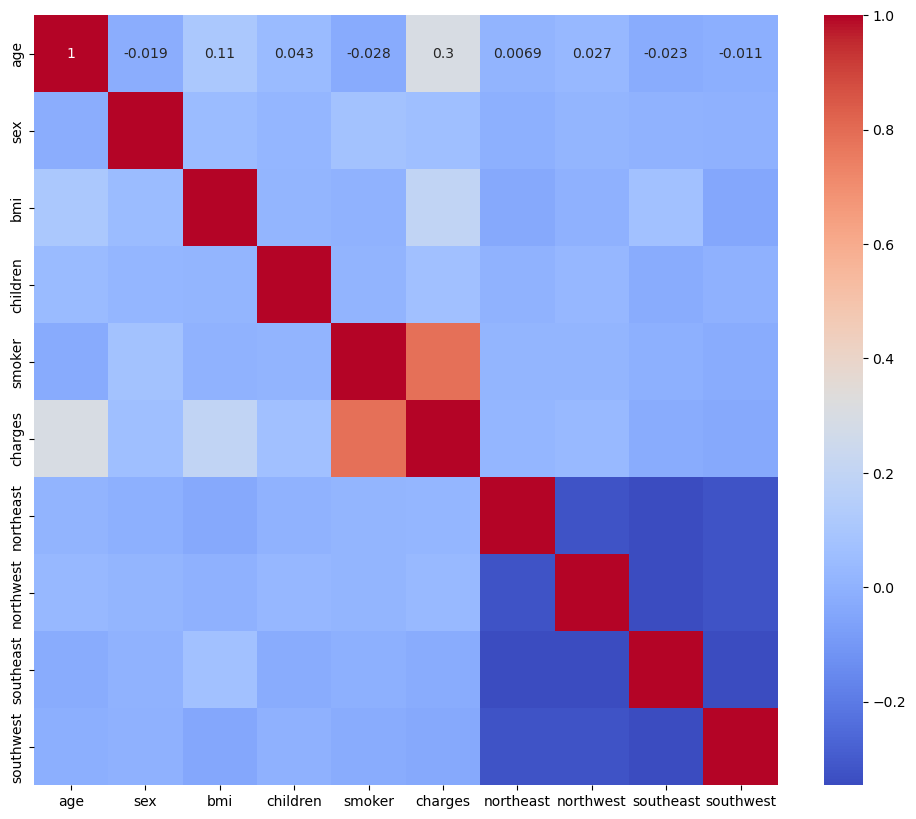

In [ ]:
# plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.show()

On remarque une forte corrélation entre le fait d'être fumeur et le coût des charges médicales.
On s'attendait à ce que l'âge et l'IMC aient une influence sur le coût des charges médicales, mais ça n'a pas l'air d'être le cas.